In [99]:
import numpy as np
import pandas as pd
import preprocessing
import nltk

In [100]:
df = pd.read_csv('spam.csv', encoding = 'cp1252')

In [101]:
df = df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

In [102]:
from sklearn.preprocessing import LabelEncoder

# encode categorical labels to numerical labels
encoder = LabelEncoder()
df['v1'] = encoder.fit_transform(df['v1'])

In [103]:
# check for duplicates
df[df.duplicated()]

,v1,v2
102,0,As per your request 'Melle Melle (Oru Minnamin...
153,0,As per your request 'Melle Melle (Oru Minnamin...
206,0,"As I entered my cabin my PA said, '' Happy B'd..."
222,0,"Sorry, I'll call later"
325,0,No calls..messages..missed calls
...,...,...
5524,1,You are awarded a SiPix Digital Camera! call 0...
5535,0,"I know you are thinkin malaria. But relax, chi..."
5539,0,Just sleeping..and surfing
5553,0,Hahaha..use your brain dear


In [104]:
df['v1'].value_counts()

v1
0    4825
1     747
Name: count, dtype: int64

<Axes: title={'center': 'Occurences of Each Label'}, xlabel='Label', ylabel='Count'>

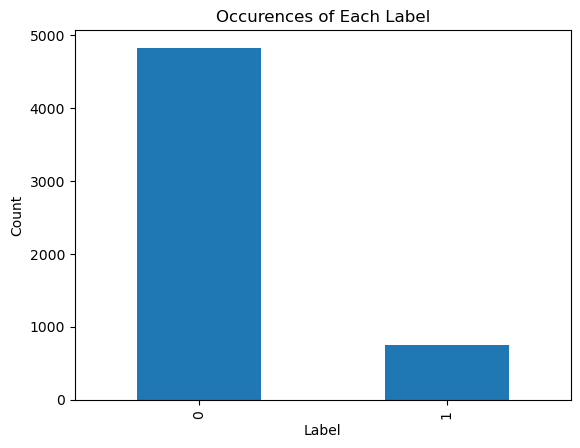

In [105]:
import matplotlib.pyplot as plt
df['v1'].value_counts().plot(kind = 'bar', xlabel = "Label", 
                             ylabel = 'Count', title = "Occurences of Each Label")

In [106]:
# drop duplicates
df = df.drop_duplicates()

In [107]:
df[df.duplicated()]

,v1,v2


In [108]:
# check for missing values
df.isnull().values.any()

False

In [109]:
# check length of messages
df['length'] = df['v2'].apply(len)
df['length'].value_counts()

length
22     91
24     91
32     90
23     86
38     82
       ..
375     1
431     1
2       1
790     1
273     1
Name: count, Length: 274, dtype: int64

In [110]:
df = df[df['v2'].apply(lambda x: len(x) < 200)]

In [111]:
# clean textual data
df['v2'] = preprocessing.lower(df['v2'])
df['v2'] = preprocessing.punc_removal(df['v2'])
df['v2'] = preprocessing.spec_char_removal(df['v2'])

In [112]:
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alihu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [113]:
tokens = df['v2'].apply(word_tokenize)

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

X = df['v2']
Y = df['v1']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 1000)
X_train_idf = vectorizer.fit_transform(X_train)
X_test_idf = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train_idf, Y_train)

Y_pred = model.predict(X_test_idf)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       887
           1       0.99      0.80      0.89       127

    accuracy                           0.97      1014
   macro avg       0.98      0.90      0.94      1014
weighted avg       0.97      0.97      0.97      1014

